In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from bs4 import BeautifulSoup
import random
import string
from collections import Counter
import jieba.posseg as pseg




# 数据来源：  
1.Wang, Y., Yang, W., Ma, F., Xu, J., Zhong, B., Deng, Q., & Gao, J. (2020). Weak Supervision for Fake News Detection via Reinforcement Learning. Proceedings of the AAAI Conference on Artificial Intelligence, 34(01), 516-523.

后面分析发现都是来自微信公众号平台

网页：

# 数据统计

In [52]:
"""文档读取csv文件"""
data = pd.read_csv('./train/train.csv')
data.head()

,id,Ofiicial Account Name,Title,News Url,Image Url,Report Content,label
0,0,朝阳实拍,范冰冰出轨被偷拍？这才是真相！,http://mp.weixin.qq.com/s?__biz=MzI1NzIzNDkxNQ...,http://mmbiz.qpic.cn/mmbiz_jpg/XUUcJo9yhYRlbzt...,发布误导信息,1
1,1,文刊,马容竟然去了非诚匆扰，一出场24盏灯全灭，孟爷爷都笑了,http://mp.weixin.qq.com/s?__biz=MzUxODE2MDMwMQ...,https://mmbiz.qlogo.cn/mmbiz_jpg/X3Cv4sIxE7Bib...,标题与内容不符##骗点击##欺骗阅读者。,1
2,2,掌上武冈,突发：武冈西站木材市场燃起大火，浓烟滚滚火势巨大，现场...,http://mp.weixin.qq.com/s?__biz=MzAwMjM0NzMxOA...,https://mmbiz.qlogo.cn/mmbiz_jpg/fnLwjhfLVGZQK...,报道内容不实，描述事实也不食,0
3,3,时事内幕爆料,辞职交警!爆`出贪 污惊人内幕！99%车主都不知道！速看,http://mp.weixin.qq.com/s?__biz=MzU3NjIzNTI5OA...,https://mmbiz.qlogo.cn/mmbiz_jpg/hYnJtOcFjEhV0...,谣言！##不实,0
4,4,大参考,美国两块让国人汗颜的告示牌，告诉我们离文明有多远,http://mp.weixin.qq.com/s?__biz=MzA5MDE4NTY4Mw...,http://mmbiz.qpic.cn/mmbiz_jpg/T0OtTToYoIR77vL...,虚假宣传##以偏概全,0


In [53]:
"""数据信息"""
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10587 entries, 0 to 10586
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     10587 non-null  int64 
 1   Ofiicial Account Name  10585 non-null  object
 2   Title                  10587 non-null  object
 3   News Url               10587 non-null  object
 4   Image Url              10587 non-null  object
 5   Report Content         10587 non-null  object
 6   label                  10587 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 579.1+ KB


In [54]:
"""读取单个html"""
# with open('./train/html/0.html', encoding='utf-8') as f:
#     html = f.read()
#     print(html)

'读取单个html'

In [55]:
"""真假新闻个数, 虚假新闻占比"""
data['label'].value_counts(), f"{data['label'].value_counts()[1]/data['label'].value_counts()[0]:.6f}"

(label
 0    7844
 1    2743
 Name: count, dtype: int64,
 '0.349694')

In [56]:
"""是否都是来自微信公众号"""
data.count(), data['News Url'].str.contains('mp.weixin.qq.com').value_counts()


(id                       10587
 Ofiicial Account Name    10585
 Title                    10587
 News Url                 10587
 Image Url                10587
 Report Content           10587
 label                    10587
 dtype: int64,
 News Url
 True    10587
 Name: count, dtype: int64)

# html分析

In [57]:
"""html文件读取"""

html_list = []
for i in tqdm(range(data.shape[0])):
    with open("./train/html/{}.html".format(i), encoding='utf-8') as f:
        html = f.read()
        html_list.append(html)
html_list = pd.Series(html_list)
html_list.head()

100%|██████████| 10587/10587 [00:17<00:00, 605.34it/s]


0    <!DOCTYPE html>\n<html class="">\n  <head>\n  ...
1    <!DOCTYPE html>\n<html class="">\n  <head>\n  ...
2    <!DOCTYPE html>\n<html class="">\n  <head>\n  ...
3    <!DOCTYPE html>\n<html class="">\n  <head>\n  ...
4    <!DOCTYPE html>\n<html class="">\n  <head>\n  ...
dtype: object

In [58]:
"""html文件长度"""
html_lengths = list(html_list.apply(lambda x: len(x)))
html_lengths_pd = pd.DataFrame(html_lengths, columns=['html_lenths'])
print("info:", html_lengths_pd.info())
print("describe:\n", html_lengths_pd.describe())
print("众数及其数量:\n", html_lengths_pd.mode())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10587 entries, 0 to 10586
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   html_lenths  10587 non-null  int64
dtypes: int64(1)
memory usage: 82.8 KB
info: None
describe:
          html_lenths
count   10587.000000
mean   178249.129876
std    252367.988048
min     17690.000000
25%     27555.000000
50%     27876.000000
75%    572228.500000
max    944942.000000
众数及其数量:
    html_lenths
0        27555


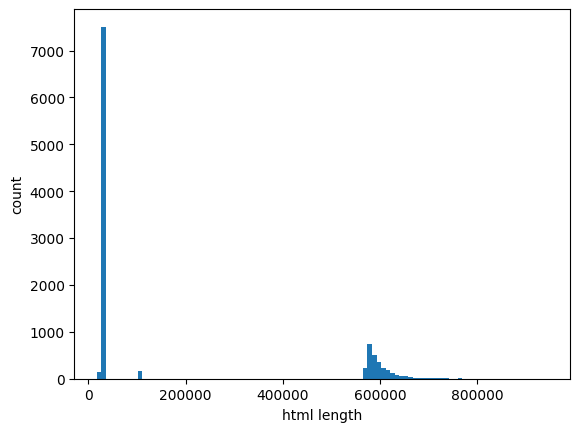

In [59]:
"""html文件长度分布图"""
plt.hist(html_lengths, bins=100)
plt.xlabel('html length')
plt.ylabel('count')
plt.show()


In [60]:
html_lengths_pd[html_lengths_pd['html_lenths'] < 200000].index

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       10568, 10569, 10571, 10573, 10575, 10576, 10577, 10581, 10582, 10585],
      dtype='int64', length=7834)

In [61]:
"""筛选html文件长度小于200000的,并得到序号"""
shortlen_html_pd = pd.DataFrame(html_lengths_pd[html_lengths_pd['html_lenths'] < 200000],
                                index = html_lengths_pd[html_lengths_pd['html_lenths'] < 200000].index)
print(shortlen_html_pd.describe())
print(shortlen_html_pd.value_counts())

         html_lenths
count    7834.000000
mean    29196.990809
std     11133.430110
min     17690.000000
25%     27555.000000
50%     27555.000000
75%     28016.000000
max    102502.000000
html_lenths
27555          4054
27673           581
28016           471
28053           362
27251           352
               ... 
24312             1
28089             1
29679             1
29519             1
27340             1
Name: count, Length: 120, dtype: int64


# text分析

In [62]:
"""通过utf-8编码将html文件中的文字和汉字符号部分提取出来"""
number = [n for n in string.digits]
chinese_symbol = ['。', '，', '！', '？', '；', '：', '“', '”', '‘', '’', '（', '）', '《', '》', '、', '…', '—', '【', '】']
text_list = []
for html in tqdm(html_list):
    soup = BeautifulSoup(html)
    chinese_text = ''.join(soup.stripped_strings)
    chinese_text = [char for char in chinese_text if '\u4e00' <= char <= '\u9fff' or char in chinese_symbol or char in number]
    text_list.append(''.join(chinese_text))


100%|██████████| 10587/10587 [01:31<00:00, 115.93it/s]


In [63]:
"""浏览"""
def showText(text_list):
    for i in range(100):
        index = random.randint(0, len(text_list))
        print(index, '\t', text_list[index])
showText(text_list)

6830 	 此账号已自主注销，内容无法查看：，。视频小程序赞，轻点两下取消赞在看，轻点两下取消在看分享留言收藏
2890 	 城事政府大院免费停车：河北“网红县城”轻松解决停车难小丸子映像正定河北有个“网红县城”，不但停车场全部免费，社会车辆还可以自由停放在机关单位内，县政府大楼内的厕所、开水间也免费对外开放。这个“网红县城”就是咱们大正定。正定县政府面向社会免费停车正定县政府院内免费停车牌子十分醒目社会车辆停放在县政府大院去年7月，正定县提出“古城新韵，自在正定”的口号，所谓“自在正定”就是让居民游客在正定旅游生活都感到“自由自在”。正定县机关单位、企业、医院拆掉了围墙和铁栅栏，开放内部停车位，允许社会车辆免费自由停放，同时县城所有停车场全部免费开放，就是“自在正定”的一项内容。在城市停车场资源普遍紧张的背景下，这一做法，对于挖潜城市的停车场资源，堪称示范。正定县医院拆除围栏前后对比图。河北新闻网图据统计，正定县这些举措使县城免费车位增加12200多个，其中，县人民医院、财政局、地税局等20多家机关事业单位，对外开放车位3000多个。正定县国家乒乓球训练基地敞开大门，对社会车辆免费停放。正定县科技馆，院内停满了社会车辆。正定广惠寺外的停车场免费停车。正定县城内的一家建设公司，拆除围墙，社会车辆可随意进入停放。“87版”红楼梦的拍摄地——正定荣国府，免费停车。正定县政府厕所和开水间也对外免费开放。放眼全国，“停车难”一直是各大城市的通病。眼下正值暑期旅游旺季，众多车辆更是涌入各大旅游城市使城市街道、景区停车场变得“一位难求”。正定县的这一举措轻松解决当地的“停车难”，市民、游客拍手称赞，其他城市相继效仿。8月7日，社会车辆驶出河北省大厂回族自治县工商局免费开放的停车场。2017年，湖南衡阳的党政机关曾在春节期间向市民开放免费停车；今年4月，哈尔滨市委以及教育局、城管局等机关单位12处531个车位首批面向市民错时开放，使用者通过手机查询共享停车场，并预约前往，有偿使用；今年6月起，河北省廊坊大厂回族自治县沿街28个单位的内部停车场错时向市民免费开放，提供了346个共享停车位，各单位138个洗手间同时免费对外开放；今年8月1日起，河南漯河市党政机关等停车场、卫生间也错时免费对外开放，首批开放单位为，四大班子机关大院，漯河市财政局、市质监局、市审计局等。……预览时标签不

In [64]:
"""数据清洗，将无用的语句、信息删除"""

dirty_words = ["：，。视频小程序赞，轻点两下取消赞在看，轻点两下取消在看",
               "分享留言收藏",
               "向上滑动看下一个知道了微信扫一扫使用小程序取消允许取消允许分析",
               "预览时标签不可点微信扫一扫关注该公众号继续滑动看下一个轻触阅读"
               ]
for index, test in enumerate(text_list):
    for dirty_word in dirty_words:
        text_list[index] = text_list[index].replace(dirty_word, '')
showText(text_list)


6610 	 此账号已被屏蔽内容无法查看由用户投诉并经平台审核，涉嫌违反相关法律法规，查看对应规则我要申诉微信公众平台运营中心
5277 	 乡村振兴：大庆在行动——肇州篇今晚看大庆实施乡村振兴战略是党的十九大提出的重大战略部署，旨在让农业成为有奔头的产业，让农民成为有吸引力的职业，让农村成为安居乐业的美丽家园。按照产业兴旺、生态宜居、乡风文明、治理有效、生活富裕的总要求，我市已经出台了《乡村振兴战略五年行动方案》并付诸实施，今天的《乡村振兴：大庆在行动》专栏，让我们一起走进肇州县。实施乡村振兴战略以来，肇州县坚持“规划先行、示范引领、统筹推进、稳步实施、注重实效”的原则，在多次调研和修改完善的基础上，制定了《肇州县乡村振兴战略五年行动方案》，对重点任务制定时间表、任务书、路线图，实行挂图作战。肇州县乡村振兴办黄福明介绍说：“综合考虑地理位置、产业基础等因素2018年肇州县确立永乐镇、兴城镇作为乡村振兴战略的试点乡镇，共同推进实施振兴项目24个，其中产业项目6个，基础设施建设项目18个，总投资135亿元。”作为肇州县乡村振兴战略试点乡镇，永乐镇永乐村充分发扬草原广茂这一地理优势，进行大鹅规模化养殖，并成立了养殖专业合作社。永乐村养殖户尹国良，凭借着自家养殖的大鹅入社，通过规模化地科学饲养，不仅大鹅的成活率得到了保障和提高，更增加了收入。肇州县永乐镇永乐村大鹅养殖合作社社长尹国良之前是个人养殖，年收入八千左右，加入合作社以后年收入三万多块钱。而且提高成活率，成活率基本是95以上。肇州县永乐镇永乐村党支部书记勾金田通过成立合作社之后，形成规模。从鹅雏的购进，到防疫销售。老百姓也非常乐意加入，今年他们养了4万只，明年争取养10万只。合作社的成立主要利于的养殖户增收，同时也带动了产业结构的调整。技术新、销路广，合作社的成立让养殖户们尝到了甜头。为了进一步带动农民增收，永乐村还进行了种植结构调整。在传统种植小麦的基础上，种植早熟黄豆品种——芽豆，让一片土地上，有了两次收成。肇州县永乐镇永乐村党支部书记勾金田：“麦子没收的时候，就把黄豆直接用点籽器点上了，黄豆出来之后，三寸多高的时候，我们就开始收小麦，麦子收完之后黄豆自然就起来了。收入能翻两三倍。”坚持“用链条、促融合”的农村产业发展理念，为提高农业生产综合实力，永乐镇还依托肇州县肉羊产业链，与中升牧业进行合作，在新隆村建立肉

In [65]:
"""保存test_list"""
text_path = "./train/text"
if not os.path.exists(text_path):
    os.makedirs(text_path)
for i, text in tqdm(enumerate(text_list)):
    with open(text_path + f'/{i}.txt', 'w', encoding='utf-8') as f:
        f.write(text + '\n')

10587it [00:05, 1815.55it/s]


In [66]:
"""被删除的文章的数量"""

dirty_key_words = ['此内容因违规无法查看', '该内容已被发布者删除', '此账号已被屏蔽内容无法查看',
                   '此账号已自主注销', '原账号迁移时未将文章素材同步至新账号']
dirty_id = [i for i, x in enumerate(text_list) for del_key_word in dirty_key_words if del_key_word in x or x == '']
right_id = [i for i in range(data.shape[0]) if i not in dirty_id]
print(len(dirty_id)+len(right_id))
del_count = len(dirty_id)
print(del_count, f"{del_count/len(text_list):.6f}")

11155
8303 0.784264


In [67]:
"""查看没有被删除的文章"""
right_text = [text_list[i] for i in right_id]
showText(right_text)

1240 	 站在海中看东营，新的水上城市——威尼斯东营（图集）原创非正常人类研究所非正常人类研究所截止到今天8月21号，这已经是雨后的第二天了，路上是这样的：上班的朋友们，出行方式也有了巨大的改变：小伙伴的娱乐项目又多了一项，那就是：地下室和小区里也遭了秧：黄河路也秒变黄河：车主们的爱车也跟着遭了秧：据东营市气象台消息8月18日12时至20日05时全市平均降水量2468毫米，其中最大广饶陈官3704毫米，全市52个站点降水量均超过100毫米，其中26个超过250毫米。今年全市累计平均9155毫米比去年同期偏多95，比历年同期偏多118。好在政府部门在积极应对这场暴雨带来的后遗症，水位也慢慢的下降了。等雨水下降了，自己的爱车要好好的清理一下了，车内进水可不是小事情，轻则让底盘锈蚀，地板发霉，重则腐蚀车内的电路板，造成安全隐患。（温馨提示：过段时间市面可能会出现一批二手车，一定要擦亮您的双眼，鉴定下是不是水淹、水泡车，如果你没有相当高超的技术，不建议购买。）家中的车库和地下室里面的东西也该清理清理了，主要将不要的东西放入垃圾桶哦一个城市的排水系统能反应这个城市的发展程度，不能只做表面的文章，总有水落石出的时候，到那个时候，被浑浊的水淹没的东西，迟早会浮出水面，狠狠的打你一耳光。原文非正常人类研究所
13 	 刚刚，军委党建会议释放7个重大信号！剑客君三剑客点上方蓝字关注三剑客侠肝义胆永不变三剑客公众号新闻通稿王士彬尹航17日至19日，中央军委一次十分重要的会议在北京召开：中央军委党的建设会议。这次会议是十九大后，军队又一次十分重要的会议，对未来一个时期都具有影响意义。新闻通稿附后，剑客着重解答一下此次会议的重大信号和干货。信号1：正风反腐更坚定不移抓下去很多人有疑问：“反腐败力度是否会减弱？”这次会议已经给出了答案：正风反腐绝不会“收官”。会议精神通稿有言：反腐败斗争必须坚定不移抓下去，不会变风转向。要坚持无禁区、全覆盖、零容忍，坚持重遏制、强高压、长震慑，坚持受贿行贿一起查，健全完善权力运行制约和监督体系，扎紧制度笼子，不给权力脱轨、越轨留空子。以铁纪而著称的人民军队，以后的追责问责的板子不仅不会迟疑，而且会提速、从严、抓关键。军中绝不能有腐败分子藏身之地。因为正风反腐，才能铸就威严铁军。信号2：深入解决选人用人突出问题选人有准头，干部有奔头。选人用人是最大的导向。

In [68]:
"""保存没有被删除的文章到right_data文件夹中"""
right_path = "./train/right_text"
if not os.path.exists(right_path):
    os.makedirs(right_path)
for i, text in tqdm(zip(right_id, right_text)):
    with open(right_path + f'/{i}.txt', 'w', encoding='utf-8') as f:
        f.write(text)


2852it [00:01, 1927.42it/s]


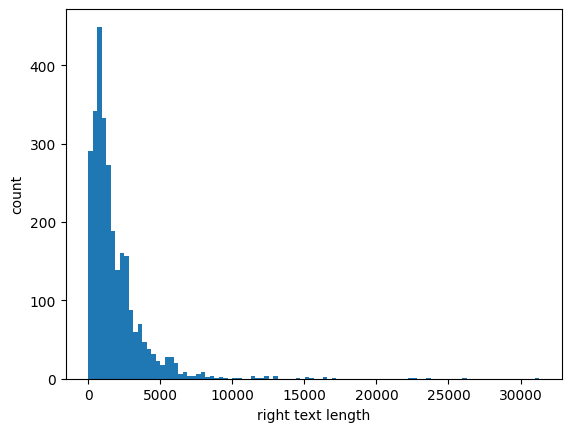

In [69]:
"""没有被删除的text文件长度分布图"""
plt.hist([len(x) for x in right_text], bins=100)
plt.xlabel('right text length')
plt.ylabel('count')
plt.show()


In [70]:
"""查看被删除的文章为虚假新闻的概率"""
del_fake_count = sum(1 for value in data['label'][dirty_id] if value == 1)
print(del_fake_count, f"{del_fake_count/del_count:.6f}")


2536 0.305432


In [71]:
"""查看未被删除的文章为虚假新闻的概率"""
right_count = sum(1 for value in data['label'][right_id] if value == 1)
print(right_count, f"{right_count/len(right_id):.6f}")

327 0.114656


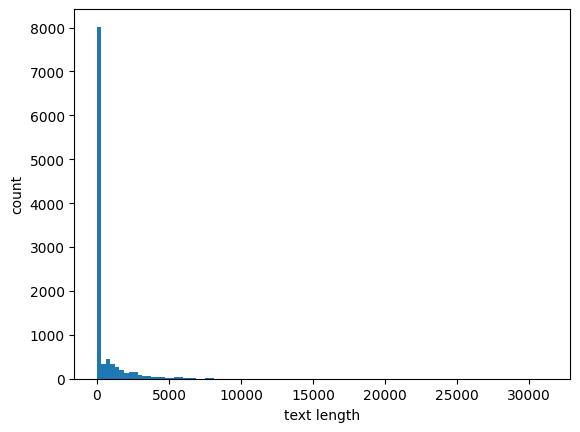

In [72]:
"""text文件长度分布图"""
plt.hist([len(x) for x in text_list], bins=100)
plt.xlabel('text length')
plt.ylabel('count')
plt.show()


In [73]:
"""text文件长度"""
text_lenths = [len(x) for x in text_list]
text_lenths_pd = pd.DataFrame(text_lenths, columns=['text_lenths'])
print("info:", text_lenths_pd.info())
print("describe:\n", text_lenths_pd.describe())
print("众数:\n", text_lenths_pd.mode())
print(text_lenths_pd.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10587 entries, 0 to 10586
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   text_lenths  10587 non-null  int64
dtypes: int64(1)
memory usage: 82.8 KB
info: None
describe:
         text_lenths
count  10587.000000
mean     525.010673
std     1341.227423
min        0.000000
25%       20.000000
50%       52.000000
75%      196.500000
max    31288.000000
众数:
    text_lenths
0           20
text_lenths
20             4059
52              708
59              551
56              361
15              352
               ... 
2034              1
2038              1
690               1
2046              1
31288             1
Name: count, Length: 1586, dtype: int64


# 特征提取

剔除被删除的文章丢弃，得到可用于训练的数据集，也就是剩下的right_id所对应的文章rifht_text，进行特征提取。

In [74]:
for i in range(10):
    print(right_text[i])

一年后退役！韦德作出最后决定终老热火！原创柚子柚子说球有时候有些消息就是这么悄无声息在我们所有人都还沉浸在甜瓜签约正要为休赛期的这个节点松一口气联盟最后一个悬念也紧接着揭晓了韦德在今天正式宣布他的未来决定可能是正在办理离职手续应接不暇这次的重磅消息轮到了爆料“韦德将与热火队续约一年继续征战，并且在下赛季结束之后选择退役！”韦大爷的最后一个赛季！韦德的动态也基本验证了这个消息他刚刚在社交媒体上发布了照片晒出自己与热火队友们训练的合照“和兄弟们一起训练！老流氓，没有牙的，黄金手臂以及我认识的最酷的人！”而詹姆斯约翰逊的配文则是：是“我们”永远不会是“他们”！这消息来得太快柚子还没能反应我们很高兴能够看见韦德重返热火再次身披3号战袍为迈阿密打拼相信这是韦德一直以来都想要的结局留在迈阿密是他从来不曾动摇的决定我们都知道浙江队曾经开出过3年2500万美元的天价希望韦德能够选择前往中国打球虽然浙江也表示自己明白这机会很小但是就是这么一点机会他们也要试试而韦德在作出最终决定之前就委婉的拒绝了来自中国的邀请他明确地对媒体表示自己还没有决定但是如果自己选择继续征战赛场的话一定会是身披热火的战袍没有别的可能同时他也解释了自己为什么拒绝在接受迈阿密当地媒体采访时他表示“我在中国有自己的品牌，如果我去那里打球会是个非常好的决定，但是家庭因素成为了我放弃的关键原因我儿子正在上高中，我想陪伴他，我要给他所有一切可能的支持现在我要为了家庭留在迈阿密不论我是否选择退役。”韦德的回归固然是一件好事每一位他的球迷都渴望再次目睹那个3号闪电侠继续在赛场驰骋只可惜这是闪电侠的最后一个赛季了这一个赛季的打拼和较量过后我们称呼韦德的方式将不是热火队员而是“迈阿密之魂，热火名宿韦德”忆往昔峥嵘岁月单枪匹马直捣黄龙闪电侠带给我们无数的经典瞬间他将自己书写进了名人堂之中也把自己刻进了球迷们的心里当年霸气劈扣瓦莱乔如今依旧高呼“这是我的马！”我们只希望这一切都不是真的柚子只想看见这条新闻的前半段但是如果这是千真万切的结局改不了的我们只能更加珍惜韦德在的最后一个赛季！——如果你喜欢我的文章可以关注微信公众号柚子说球预览时标签不可点阅读原文微信扫一扫关注该公众号继续滑动看下一个轻触阅读原文柚子说球
著名主持人朱军被爆性骚扰实习女生！泗州文艺昨天，新浪微博百万粉丝大罗昌平发微博，内容为某匿名网友发长文控诉央视名主持朱军对自

In [75]:
right_data = data.iloc[right_id]
# 保存
with open("./train/right_data.csv", 'w', encoding='utf-8') as f:
    right_data.to_csv(f, index=False)

# 保存label为1的数据
with open("./train/right_data_fake.csv", 'w', encoding='utf-8') as f:
    right_data[right_data['label'] == 1].to_csv(f, index=False)
# 保存label为0的数据
with open("./train/right_data_real.csv", 'w', encoding='utf-8') as f:
    right_data[right_data['label'] == 0].to_csv(f, index=False)

right_data.head(10)
    

,id,Ofiicial Account Name,Title,News Url,Image Url,Report Content,label
10,10,柚子说球,一年后退役！韦德作出最后决定终老热火！,http://mp.weixin.qq.com/s?__biz=MzIxOTI5NTk5MQ...,http://mmbiz.qpic.cn/mmbiz_jpg/6sMnWYZVWaR85gd...,未经证实散步韦德退役谣言,0
11,11,泗县城市网,著名主持人朱军被爆性骚扰实习女生！,http://mp.weixin.qq.com/s?__biz=MzIxMzAyNzU5NQ...,http://mmbiz.qpic.cn/mmbiz_jpg/qtGJibt7gqfPS4V...,未经证实,1
16,16,女神生活街,郑恺新恋情曝光，将和他携手退出跑男？网友：迪丽热巴暗讽看真相,http://mp.weixin.qq.com/s?__biz=MzIyODUzNjk5MA...,http://mmbiz.qpic.cn/mmbiz_jpg/ayhEAOFHVILicQD...,毫无根据，言语混乱,1
17,17,房里房外,台前县吴坝镇黄河滩区迁建成果初现，街亮了，家新了，腰包鼓了，昔日穷滩区，今日新城镇，国家扶贫...,http://mp.weixin.qq.com/s?__biz=MzA4NjQ1OTY0OA...,http://mmbiz.qpic.cn/mmbiz_jpg/92LsX90lExTEwuO...,我们不是滩区，为什么拆我们的房子。老百姓越来越穷，搬不起。##这个发表文章记者认识他受贿，他...,0
18,18,海门大神,@所有海门人！海门各乡镇微信群开通了！现邀请您来一起噶闹忙咯！！！,http://mp.weixin.qq.com/s?__biz=MzU5MzA0NTQzNw...,http://mmbiz.qpic.cn/mmbiz_jpg/ZibsiaicPwOia7i...,各群都是无聊退应该取缔,0
20,20,参考消息,德媒：被中国打中“七寸” 美国农民对贸易争端失去耐心,http://mp.weixin.qq.com/s?__biz=MjM5MzA0MTg2MA...,http://mmbiz.qpic.cn/mmbiz_jpg/F1hLEK71icuAQkk...,你没有你吹牛逼那么强大,0
22,22,爱临汾,忻州中西医结合医院造假大量骗取医保资金,http://mp.weixin.qq.com/s?__biz=MzU0MTcyMjg4MQ...,http://mmbiz.qpic.cn/mmbiz_jpg/gypEaBqfcibXQKw...,不实信息##不实信息,0
23,23,科技犬,卓伟爆料！某女星同侍父子俩，网友脑洞大开，上演名侦探柯南！,http://mp.weixin.qq.com/s?__biz=MzIwNDMyNTk0Ng...,http://mmbiz.qpic.cn/mmbiz_jpg/M4RkZsDvOoGyCJ7...,标题与内容严重不符,1
28,28,嘿星期八,别在危险的边缘试探噢,http://mp.weixin.qq.com/s?__biz=MzUzMjk0MzQyOA...,http://mmbiz.qpic.cn/mmbiz_jpg/IrQdFP8BsWUlNmV...,文中说潮州交通很乱，这点本地人不承认,0
31,31,潍坊论坛,定了！潍坊划入“青岛圈”！,http://mp.weixin.qq.com/s?__biz=MjM5MDA0MzA0Nw...,http://mmbiz.qpic.cn/mmbiz_jpg/b3GzIor9icsO0Tu...,谣言吧,0


In [76]:
"""文本长度 length"""
text_length = pd.Series([text_lenths[i] for i in right_id])
text_length
"""标题长度 title_length"""
title_length = pd.Series([len(data['Title'][i]) for i in right_id])
title_length

0       19
1       17
2       30
3       62
4       33
        ..
2847     9
2848    25
2849    30
2850    25
2851    25
Length: 2852, dtype: int64

In [77]:
"""引号、感叹号、问号引用比率 quote_symbol_rate strong_emotion_symbol_rate"""
symbol_count = []
for text in right_text:
    symbol_count.append(sum(1 for char in text if char in chinese_symbol))
symbol_count = pd.Series(symbol_count)

quote_symbol_count = []
for text in right_text:
    quote_symbol_count.append(sum(1 for char in text if char == '“' or char == '”'))
quote_symbol_count = pd.Series(quote_symbol_count)

strong_emotion_symbol_count = []
for text in right_text:
    strong_emotion_symbol_count.append(sum(1 for char in text if char == '！' or char == '？'))
strong_emotion_symbol_count = pd.Series(strong_emotion_symbol_count)

quote_symbol_rate = quote_symbol_count / symbol_count
strong_emotion_symbol_rate = strong_emotion_symbol_count / symbol_count  

# 归一化
quote_symbol_rate = (quote_symbol_rate - quote_symbol_rate.min()) / (quote_symbol_rate.max() - quote_symbol_rate.min())
strong_emotion_symbol_rate = (strong_emotion_symbol_rate - strong_emotion_symbol_rate.min()) / (strong_emotion_symbol_rate.max() - strong_emotion_symbol_rate.min())

print(quote_symbol_rate.head())
print(strong_emotion_symbol_rate.head())

0    0.496296
1    0.000000
2    0.145969
3    0.000000
4    0.000000
dtype: float64
0    0.257143
1    0.086957
2    0.264706
3    0.010309
4    0.500000
dtype: float64


In [78]:
"""来源包含娱乐、八卦、搞笑"""
source_from_entertainment = []
for i in right_id:
    if "娱乐" in data['Ofiicial Account Name'][i] or "八卦" in data[
        'Ofiicial Account Name'][i] or "搞笑" in data['Ofiicial Account Name'][i]:
        source_from_entertainment.append(1)
    else:
        source_from_entertainment.append(0)
source_from_entertainment = pd.Series(source_from_entertainment)
source_from_entertainment

0       0
1       0
2       0
3       0
4       0
       ..
2847    0
2848    0
2849    0
2850    0
2851    0
Length: 2852, dtype: int64

In [79]:
"""标签包含人名"""
title_contains_person = []
for i in right_id:
    words = pseg.cut(data['Title'][i])
    count = 0
    for word, flag in words:
        if flag == 'nr':
            count += 1
    title_contains_person.append(count)

title_contains_person = pd.Series(title_contains_person)
# 归一化
title_contains_person = (title_contains_person - title_contains_person.min()) / (title_contains_person.max() - title_contains_person.min())
title_contains_person

0       0.2
1       0.2
2       0.2
3       0.2
4       0.0
       ... 
2847    0.0
2848    0.4
2849    0.0
2850    0.0
2851    0.2
Length: 2852, dtype: float64

In [95]:
right_label_list = right_data['label'].to_list()
right_label_pd = pd.Series(right_label_list)
right_label_pd

0       0
1       1
2       1
3       0
4       0
       ..
2847    0
2848    1
2849    0
2850    0
2851    0
Length: 2852, dtype: int64

In [98]:
"""特征整合"""
my_train = pd.concat([pd.Series(right_id), text_length, title_length, quote_symbol_rate, strong_emotion_symbol_rate, 
                      source_from_entertainment, title_contains_person, right_label_pd], axis=1)
my_train.columns = ['id', 'text_length', 'title_length', 'quote_symbol_rate', 'strong_emotion_symbol_rate', 
                    'source_from_entertainment', 'title_contains_person', 'label']
my_train.head() 


,id,text_length,title_length,quote_symbol_rate,strong_emotion_symbol_rate,source_from_entertainment,title_contains_person,label
0,10,937,19,0.496296,0.257143,0,0.2,0
1,11,235,17,0.000000,0.086957,0,0.2,1
2,16,904,30,0.145969,0.264706,0,0.2,1
3,17,2204,62,0.000000,0.010309,0,0.2,0
4,18,378,33,0.000000,0.500000,0,0.0,0


In [99]:
"""保存"""
my_train.to_csv("./train/my_train.csv", index=False)